# Make cumulative plot of Event

## import libraries

In [1]:
from datetime import datetime
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from ligo.gracedb.rest import GraceDb
from astropy.time import Time

## define constants

In [2]:
# FAR_LIMIT = 1.0/(30*24*3600) # < 1/Month
#FAR_LIMIT = 1.0/(20*24*3600) # < 1/Month
FAR_LIMIT = 0.5e-7 # < 1/Month

## define catalog events retrieve function

In [3]:
def retrieve_catalog_events():
    events = []
    results = requests.get('https://gwosc.org/api/v2/catalogs/GWTC/events').json()
    # print(len(results['results']))
    events=results['results']
    # print(len(events))
    while results['next'] is not None:
        results = requests.get(results['next']).json()
        events = events + results['results']
    # print(len(events))
    return events

## define retrieve event detail function

In [4]:
def retrieve_event_detail(superevent):
    event_detail = requests.get(superevent['detail_url']).json()
    superevent['event_detail'] = event_detail
    event_parameter = requests.get(event_detail['parameters_url']).json()
    superevent['event_detail']['parameters'] = [parameters for parameters in event_parameter['results'] if parameters['pipeline_type']=='pe']

## define GraceDb retrieve function

In [5]:
def retrieve_events(observations):
    print(f"======= observations = {observations}")
    catalog_events = retrieve_catalog_events()
    for superevent in catalog_events:
        for key in observations.keys():
            obs = observations[key]
            obs_start = obs["start"].strftime("%Y-%m-%d %H:%M:%S")
            obs_end = obs["end"].strftime("%Y-%m-%d %H:%M:%S")
            t_start = Time(obs_start, format='iso', scale='utc')
            t_end = Time(obs_end, format='iso', scale='utc')
            if superevent['gps'] >= t_start.gps and superevent['gps'] < t_end.gps:
                #print("======== ADDED ===============")
                #print(superevent)
                #print(f"observations[obs]['events'] = {obs['events']}")
                retrieve_event_detail(superevent)
                obs['events'].append(superevent)
                #print("=========================================")
    checked_obs = [key for key in observations.keys() if len(observations[key]['events']) >0]
    print(f"checked_obs = {checked_obs}")
    client = GraceDb()
    results = client.superevents(orderby=['-preferred_event'])
    
    #print(f"dir(results) = {dir(results)}")
    # Print event IDs
    for superevent in results:
        #print(f"superevent = {superevent}")
        for key in observations.keys():
            obs = observations[key]
            if key not in checked_obs: # not checked yet
                obs_start = obs["start"].strftime("%Y-%m-%d %H:%M:%S")
                obs_end = obs["end"].strftime("%Y-%m-%d %H:%M:%S")
                t_start = Time(obs_start, format='iso', scale='utc')
                t_end = Time(obs_end, format='iso', scale='utc')
                if superevent['category'] == 'Production' and superevent['t_0'] >= t_start.gps and superevent['t_0'] < t_end.gps and superevent['far'] < FAR_LIMIT:
                    #print(f"======== ADDED for {obs['name']} ===============")
                    #print(f"superevent['t_0'] = {superevent['t_0']}, t_start.gps = {t_start.gps}, t_end.gps = {t_end.gps}")
                    #print(superevent)
                    #print(f"observations[obs]['events'] = {obs['events']}")
                    obs['events'].append(superevent)
                    #print("=========================================")
    catalog_event_number = 0
    online_event_number = 0
    for key in observations.keys():
        obs = observations[key]
        print(f"Number of events for {obs['name']} is {len(obs['events'])}")
        obs['n_events'] = len(obs['events'])
        if obs['status'] == 'GWTC':
            catalog_event_number = catalog_event_number + obs['n_events']
        elif obs['status'] == 'online':
            online_event_number = online_event_number + obs['n_events']
    return catalog_event_number, online_event_number

## define event print function

In [6]:
def show_event(superevent):
    pretty_event = json.dumps(superevent, indent=2)
    print(pretty_event)

## define observation periods

In [7]:
observations = {
    "O1": {"name": "O1", "start": datetime(2015,9,12, 15,0,0), "end": datetime(2016,1,19, 16, 0, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"GWTC", "events": [], "breaks":[]},
    "O2": {"name": "O2", "start": datetime(2016,11,30, 16,0,0), "end": datetime(2017,8,25, 22, 0, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"GWTC", "events": [], "breaks":[]},
    "O3a": {"name": "O3a", "start": datetime(2019,4,1, 15,0,0), "end": datetime(2019,10,1, 15, 0, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"GWTC", "events": [], "breaks":[]},
    "O3b": {"name": "O3b", "start": datetime(2019,11,1, 15,0,0), "end": datetime(2020,3,27, 17, 0, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"GWTC", "events": [], "breaks":[]},
    "O4a": {"name": "O4a", "start": datetime(2023,5,24, 14, 0, 0), "end": datetime(2024,1,16, 15, 59, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"online", "events": [], "breaks":[]},
    "O4b": {"name": "O4b", "start": datetime(2024,4,10, 15,0,0), "end": datetime(2025,1,28, 17, 0, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"online", "events": [], "breaks":[]},
    "O4c": {"name": "O4c", "start": datetime(2025,1,28, 17,0,0), "end": datetime(2025,11,18, 16, 0, 0), "len": 0, "accum_len":0, "n_events":3, "accum_events":0, "status":"online", "events": [], "breaks":[{"start": datetime(2025, 4, 1, 16, 0, 0), "end": datetime(2025, 6, 4, 16,0,0)}]},
                }

In [8]:
catalog_event_number, online_event_number = retrieve_events(observations)

======= observations = {'O1': {'name': 'O1', 'start': datetime.datetime(2015, 9, 12, 15, 0), 'end': datetime.datetime(2016, 1, 19, 16, 0), 'len': 0, 'accum_len': 0, 'n_events': 3, 'accum_events': 0, 'status': 'GWTC', 'events': [], 'breaks': []}, 'O2': {'name': 'O2', 'start': datetime.datetime(2016, 11, 30, 16, 0), 'end': datetime.datetime(2017, 8, 25, 22, 0), 'len': 0, 'accum_len': 0, 'n_events': 3, 'accum_events': 0, 'status': 'GWTC', 'events': [], 'breaks': []}, 'O3a': {'name': 'O3a', 'start': datetime.datetime(2019, 4, 1, 15, 0), 'end': datetime.datetime(2019, 10, 1, 15, 0), 'len': 0, 'accum_len': 0, 'n_events': 3, 'accum_events': 0, 'status': 'GWTC', 'events': [], 'breaks': []}, 'O3b': {'name': 'O3b', 'start': datetime.datetime(2019, 11, 1, 15, 0), 'end': datetime.datetime(2020, 3, 27, 17, 0), 'len': 0, 'accum_len': 0, 'n_events': 3, 'accum_events': 0, 'status': 'GWTC', 'events': [], 'breaks': []}, 'O4a': {'name': 'O4a', 'start': datetime.datetime(2023, 5, 24, 14, 0), 'end': dateti

## calculate days of observation

In [9]:
total_days = 0
accum_events = 0
for key in observations.keys():
    observations[key]['len'] = (observations[key]['end']-observations[key]['start']).days
    if len(observations[key]['breaks']) > 0: # remove days in break time periods
        print(f"Original obs days for {key} = {observations[key]['len']}")
        for break_period in observations[key]['breaks']:
            observations[key]['len'] = observations[key]['len'] - (break_period['end']-break_period['start']).days
        print(f"Corrected obs days for {key} = {observations[key]['len']}")
    total_days = total_days + observations[key]['len']
    observations[key]['accum_len'] = total_days
    observations[key]['n_events'] = len(observations[key]['events'])
    accum_events = accum_events + observations[key]['n_events']
    observations[key]['accum_events'] = accum_events
for key in observations.keys():
    print(f"For observation {key} :")
    for superevent in observations[key]['events']:
        show_event(superevent)
for key in observations.keys():
    print(f"For observation {key} :")
    print(f"    observation days = {observations[key]['len']}")
    print(f"    accumulated days = {observations[key]['accum_len']}")
    print(f"    accumulated events = {observations[key]['accum_events']}")


Original obs days for O4c = 293
Corrected obs days for O4c = 229
For observation O1 :
{
  "name": "GW151226",
  "shortName": "GW151226-v2",
  "gps": 1135136350.6,
  "version": 2,
  "catalog": "GWTC-1-confident",
  "doi": "https://doi.org/10.7935/82H3-HH23",
  "detectors": [
    "H1",
    "L1"
  ],
  "detail_url": "https://gwosc.org/api/v2/event-versions/GW151226-v2",
  "event_detail": {
    "name": "GW151226",
    "gps": 1135136350.6,
    "version": 2,
    "catalog": "GWTC-1-confident",
    "run": "O1",
    "grace_id": "G211117",
    "aliases": [
      "GW151226"
    ],
    "gcn_notice": "https://gcn.gsfc.nasa.gov/notices_l/G211117.lvc",
    "gcn_circular": "https://gcn.nasa.gov/circulars?query=G211117",
    "doi": "https://doi.org/10.7935/82H3-HH23",
    "detectors": [
      "H1",
      "L1"
    ],
    "parameters_url": "https://gwosc.org/api/v2/event-versions/GW151226-v2/parameters",
    "timelines_url": "https://gwosc.org/api/v2/event-versions/GW151226-v2/timelines",
    "strain_fil

## plot accumulative events

For observation O1, start time = 2015-09-12 15:00:00
  obs_event_days = [104, 29, 1]
  sorted obs_event_days = [1, 29, 104]
   End of observation - last event = 24 days
   O1: obs_start_days = [1]
   O1: event_days_catalog = [1, 29, 104]
   O1: event_days_online = []
For observation O2, start time = 2016-11-30 16:00:00
  obs_event_days = [265, 260, 259, 256, 251, 241, 189, 34]
  sorted obs_event_days = [34, 189, 241, 251, 256, 259, 260, 265]
  slide_obs_event_days = [163, 318, 370, 380, 385, 388, 389, 394]
   End of observation - last event = 2 days
   O2: obs_start_days = [1, 129]
   O2: event_days_catalog = [1, 29, 104, 163, 318, 370, 380, 385, 388, 389, 394]
   O2: event_days_online = []
For observation O3a, start time = 2019-04-01 15:00:00
  obs_event_days = [181, 180, 177, 177, 175, 168, 168, 167, 161, 148, 148, 135, 126, 123, 120, 117, 116, 115, 109, 109, 98, 96, 96, 91, 90, 79, 62, 55, 49, 49, 48, 45, 42, 42, 41, 32, 25, 23, 20, 11, 11, 10, 7, 1]
  sorted obs_event_days = [1, 7,

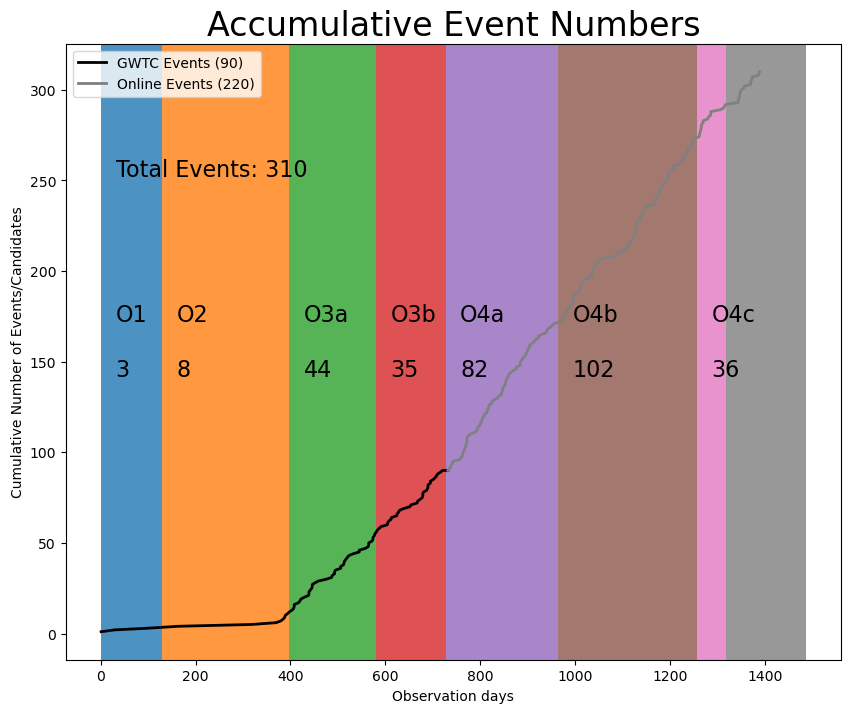

In [14]:
event_days = []
event_days_catalog = []
event_days_online = []
online_start = -1
obs_start_days = []

for idx, key in enumerate(observations.keys()):
    obs_event_days = []
    last_event = None
    for superevent in observations[key]['events']:
        if 't_0' in superevent.keys():
            event_datetime = Time(superevent['t_0'], format='gps', scale='utc').to_datetime()
            obs_event_days.append((event_datetime - observations[key]['start']).days)
            if len(observations[key]['breaks']) > 0: # remove days in break time periods
                for break_period in observations[key]['breaks']:
                    # print(f"{key}: event_datetime = {event_datetime}, break_period['end'] = {break_period['end']}, event_datetime > break_period['end'] = {event_datetime > break_period['end']}")
                    if event_datetime > break_period['end']:
                        obs_event_days[-1] = obs_event_days[-1] - (break_period['end']-break_period['start']).days
        elif 'gps' in superevent.keys():
            event_datetime = Time(superevent['gps'], format='gps', scale='utc').to_datetime()
            obs_event_days.append((event_datetime - observations[key]['start']).days)
            if len(observations[key]['breaks']) > 0: # remove days in break time periods
                for break_period in observations[key]['breaks']:
                    # print(f"{key}: event_datetime = {event_datetime}, break_period['end'] = {break_period['end']}, event_datetime > break_period['end'] = {event_datetime > break_period['end']}")
                    if event_datetime > break_period['end']:
                        obs_event_days[-1] = obs_event_days[-1] - (break_period['end']-break_period['start']).days
        if last_event is None:
            last_event = event_datetime
    print(f"For observation {key}, start time = {observations[key]['start']}")
    print(f"  obs_event_days = {obs_event_days}")
    obs_event_days = sorted(obs_event_days)
    print(f"  sorted obs_event_days = {obs_event_days}")
    if idx > 0:
        slide_obs_event_days = [x + observations[prev_key]['accum_len'] for x in obs_event_days]
        print(f"  slide_obs_event_days = {slide_obs_event_days}")
        event_days = event_days + slide_obs_event_days
        if observations[key]['status'] == 'online':
            event_days_online = event_days_online + slide_obs_event_days
            if online_start < 0:
                online_start = observations[prev_key]['accum_events']
        else:
            event_days_catalog = event_days_catalog + slide_obs_event_days
        if len(observations[key]['breaks']) > 0: # remove days in break time periods
            obs_start_days.append(observations[prev_key]['accum_len'])
            print(f"   {key}: obs_start_days = {obs_start_days}")
            for break_period in observations[key]['breaks']:
                obs_start_days.append((break_period['start'] - observations[key]['start']).days + observations[prev_key]['accum_len'])
                print(f"{key}: obs_start_days = {obs_start_days}")
        else:
            obs_start_days.append(observations[prev_key]['accum_len'])
    else:
        event_days = event_days + obs_event_days
        if observations[key]['status'] == 'online':
            if online_start < 0:
                event_days_online = obs_event_days
                online_start = observations[prev_key]['accum_events']
            else:
                event_days_online = event_days_online + obs_event_days
        else:
            event_days_catalog = event_days_catalog + obs_event_days
        obs_start_days.append(1)
    print(f"   End of observation - last event = {(observations[key]['end'] - last_event).days} days")
    print(f"   {key}: obs_start_days = {obs_start_days}")
    print(f"   {key}: event_days_catalog = {event_days_catalog}")
    print(f"   {key}: event_days_online = {event_days_online}")
    prev_key = key

print(f"Events days = {event_days}")
event_days_catalog.append(event_days_online[0])
print(f"Events days catalog = {event_days_catalog}")
print(f"Events days online = {event_days_online}")
accum_numbers = np.linspace(1, accum_events, accum_events, dtype=int)
accum_numbers_catalog = np.linspace(1, online_start, online_start, dtype=int)
accum_numbers_catalog = np.append(accum_numbers_catalog, online_start)
accum_numbers_online = np.linspace(online_start, accum_events, accum_events - online_start, dtype=int)
#print(f"Acumulative numbers = {accum_numbers}")
css_colors = list(colors.CSS4_COLORS.keys())
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
used_colors = default_colors
fig, ax = plt.subplots(figsize=(10,8))
# plt.figure(figsize=(10,8))
plt.title("Accumulative Event Numbers", fontsize=24)
# plt.plot(event_days, accum_numbers, color='black', linewidth=2, linestyle='-', label='Total Events')
plt.plot(event_days_catalog, accum_numbers_catalog, color='black', linewidth=2, linestyle='-', label=f'GWTC Events ({catalog_event_number})')
# plt.plot([event_days_catalog[-1],event_days_online[0]], [accum_numbers_catalog[-1],accum_numbers_catalog[-1]], color='black', linewidth=2, linestyle='-', label='GWTC Events')
plt.plot(event_days_online, accum_numbers_online, color='#808080', linewidth=2, linestyle='-', label=f'Online Events ({online_event_number})')
color_segment = 0
for key in observations.keys():
    obs = observations[key]
    obs_name = obs['name']
    if len(obs['breaks']) > 0:
        for idx in range(len(obs['breaks'])+1):
            print(f"{obs_name}: color_segment = {color_segment}, len(obs_start_days) - 1 = {len(obs_start_days) - 1}, idx = {idx}")
            if color_segment < len(obs_start_days) - 1:
                print(f"{obs_name}: obs_start_days[color_segment] = {obs_start_days[color_segment]}, obs_start_days[color_segment+1] = {obs_start_days[color_segment+1]}")
                ax.axvspan(obs_start_days[color_segment], obs_start_days[color_segment+1], facecolor=used_colors[color_segment], alpha=0.8)
                if idx == 0:
                    ax.annotate(obs_name, xy=(obs_start_days[color_segment]+30, 170), xytext=(obs_start_days[color_segment]+30.5, 172), fontsize=16)
                    ax.annotate(len(obs['events']), xy=(obs_start_days[color_segment]+30, 140), xytext=(obs_start_days[color_segment]+30.5, 142), fontsize=16)
            else:
                print(f"{obs_name}: obs_start_days[color_segment] = {obs_start_days[color_segment]}, total_days = {total_days}")
                ax.axvspan(obs_start_days[color_segment], total_days, facecolor=used_colors[color_segment], alpha=0.8)
                # ax.annotate(obs_name, xy=(obs_start_days[color_segment]+5, 170), xytext=(obs_start_days[color_segment]+5.5, 172), fontsize=16)
            color_segment = color_segment + 1
    else:
        print(f"{obs_name}: color_segment = {color_segment}, len(obs_start_days) - 1 = {len(obs_start_days) - 1}")
        if color_segment < len(obs_start_days) - 1:
            print(f"{obs_name}: obs_start_days[color_segment] = {obs_start_days[color_segment]}, obs_start_days[color_segment+1] = {obs_start_days[color_segment+1]}")
            ax.axvspan(obs_start_days[color_segment], obs_start_days[color_segment+1], facecolor=used_colors[color_segment], alpha=0.8)
            ax.annotate(obs_name, xy=(obs_start_days[color_segment]+30, 170), xytext=(obs_start_days[color_segment]+30.5, 172), fontsize=16)
            ax.annotate(len(obs['events']), xy=(obs_start_days[color_segment]+30, 140), xytext=(obs_start_days[color_segment]+30.5, 142), fontsize=16)
        else:
            print(f"{obs_name}: obs_start_days[color_segment] = {obs_start_days[color_segment]}, total_days = {total_days}")
            ax.axvspan(obs_start_days[color_segment], total_days, facecolor=used_colors[color_segment], alpha=0.8)
            ax.annotate(obs_name, xy=(obs_start_days[color_segment]+30, 170), xytext=(obs_start_days[color_segment]+30.5, 172), fontsize=16)
            ax.annotate(len(obs['events']), xy=(obs_start_days[color_segment]+30, 140), xytext=(obs_start_days[color_segment]+30.5, 142), fontsize=16)
        color_segment = color_segment + 1

ax.annotate(f'Total Events: {catalog_event_number + online_event_number}', xy=(obs_start_days[0]+30, 250), xytext=(obs_start_days[0]+30.5, 252), fontsize=16)

plt.xlabel("Observation days")
plt.ylabel("Cumulative Number of Events/Candidates")
plt.legend()
plt.show()
fig.savefig('accum_events.png')